I this notebook I use partial district information of the election 2021 to predict the full election results. I use the full results of 2016 to improve the results. 

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns


from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split

First I load the results of the two elections. In both the votes have two votes, the second vote is much more important and thus I concentrate on it. 

In [86]:
elec16_vote1=pd.read_excel('DL_BE_EE_WB_AH2016.xlsx',sheet_name='Erststimme')
print(elec16_vote1.columns)
elec16_vote2=pd.read_excel('DL_BE_EE_WB_AH2016.xlsx',sheet_name='Zweitstimme')
print(elec16_vote2.columns)
elec21_vote1=pd.read_excel('DL_BE_AGHBVV2021.xlsx',sheet_name='AGH_W1')
elec21_vote2=pd.read_excel('DL_BE_AGHBVV2021.xlsx',sheet_name='AGH_W2')
print(elec21_vote1.columns)
print(elec21_vote2.columns)

Index(['Adresse', 'Stimmart', 'Bezirksnummer', 'Bezirksname', 'Wahlbezirk',
       'Wahlbezirksart', 'Abgeordneten-\nhauswahlkreis',
       'Bundestags-\nwahlkreis', 'Berlin\nOstWest',
       'Wahlberechtigte insgesamt', 'Wahlberechtigte A1', 'Wahlberechtigte A2',
       'Wahlberechtigte A3', 'Wähler', 'Wähler B1', 'Ungültige Stimmen',
       'Gültige Stimmen', 'SPD', 'CDU', 'GRÜNE', 'DIE LINKE', 'PIRATEN', 'NPD',
       'FDP', 'Tierschutzpartei', 'pro Deutschland', 'Die PARTEI', 'BIG',
       'DKP', 'ödp', 'PSG', 'BüSo', 'B', 'DL', 'ALFA', 'Tierschutzallianz',
       'AfD', 'DIE EINHEIT', 'DIE VIOLETTEN', 'Graue Panther',
       'MENSCHLICHE WELT', 'MIETERPARTEI', 'Gesundheits-\nforschung', 'EB 1',
       'EB 2', 'EB 3', 'EB 4', 'EB 5', 'EB 6', 'EB 7', 'EB 8', 'EB 9', 'EB 10',
       'EB 11', 'EB 12', 'EB 13', 'EB 14', 'EB 15', 'EB 16', 'EB 17', 'EB 18'],
      dtype='object')
Index(['Adresse', 'Stimmart', 'Bezirksnummer', 'Bezirksname', 'Wahlbezirk',
       'Wahlbezirksart', 'Abgeord

Now I merge the second vote of the two years using the keys.

In [3]:
combined=elec21_vote2.merge(elec16_vote2,how='left',left_on='Adresse',right_on='Adresse')

In [4]:
print(combined.shape)
print(elec21_vote2.shape)
print(elec16_vote2.shape)
print(combined.columns)

(3764, 95)
(3764, 53)
(2432, 43)
Index(['Stimmart_x', 'Adresse', 'Bezirksnummer_x', 'Bezirksname_x',
       'Wahlbezirk_x', 'Wahlbezirksart_x', 'Briefwahlbezirk',
       'Abgeordneten-\nhauswahlkreis_x', 'Bundestags-\nwahlkreis_x', 'OstWest',
       'Wahlberechtigte insgesamt_x', 'Wahlberechtigte A1_x',
       'Wahlberechtigte A2_x', 'Wahlberechtigte A3_x', 'Wählende',
       'Wählende B1', 'Gültige Stimmen_x', 'Ungültige Stimmen_x', 'SPD_x',
       'CDU_x', 'GRÜNE_x', 'DIE LINKE_x', 'AfD_x', 'FDP_x', 'Die PARTEI_x',
       'Tierschutzpartei_x', 'PIRATEN_x', 'Graue Panther_x', 'NPD_x',
       'Gesundheitsforschung', 'LKR', 'DKP_x', 'SGP', 'BüSo_x',
       'MENSCHLICHE WELT_x', 'B*', 'ÖDP', 'TIERSCHUTZ hier!', 'dieBasis',
       'Bildet Berlin!', 'Deutsche Konservative', 'Die Grauen',
       'Neue Demokraten', 'REP', 'du.', 'BÜNDNIS21', 'FREIE WÄHLER',
       'Klimaliste Berlin', 'MIETERPARTEI_x', 'Die Humanisten',
       'Team Todenhöfer', 'Volt', 'aufn', 'Stimmart_y', 'Bezirksnummer_y

The number of rows is clearly different in the two tables. That means there is not always a perfect match which makes predictions more difficult. 

Below I print some prorties of these districts, to understand teh reasons ofr the missmacthes

In [5]:
nulls=combined.Bezirksnummer_y.isnull()
n_null=0
for i in range(combined.shape[0]):
    if nulls[i]==True:
        print(combined.iloc[i,1:18])
        n_null+=1
print(f"number of NULL {n_null}")
print(f"difference in election districts{elec21_vote2.shape[0]-elec16_vote2.shape[0]}") 

Adresse                           01B1F
Bezirksnummer_x                       1
Bezirksname_x                     Mitte
Wahlbezirk_x                         1F
Wahlbezirksart_x                      B
Briefwahlbezirk                    011F
Abgeordneten-\nhauswahlkreis_x        1
Bundestags-\nwahlkreis_x             75
OstWest                               O
Wahlberechtigte insgesamt_x           0
Wahlberechtigte A1_x                  0
Wahlberechtigte A2_x                  0
Wahlberechtigte A3_x                  0
Wählende                            935
Wählende B1                         935
Gültige Stimmen_x                   927
Ungültige Stimmen_x                   8
Name: 5, dtype: object
Adresse                           01B1G
Bezirksnummer_x                       1
Bezirksname_x                     Mitte
Wahlbezirk_x                         1G
Wahlbezirksart_x                      B
Briefwahlbezirk                    011G
Abgeordneten-\nhauswahlkreis_x        1
Bundestags-\nwahl

Adresse                                                04B2N
Bezirksnummer_x                                            4
Bezirksname_x                     Charlottenburg-Wilmersdorf
Wahlbezirk_x                                              2N
Wahlbezirksart_x                                           B
Briefwahlbezirk                                         042N
Abgeordneten-\nhauswahlkreis_x                             2
Bundestags-\nwahlkreis_x                                  80
OstWest                                                    W
Wahlberechtigte insgesamt_x                                0
Wahlberechtigte A1_x                                       0
Wahlberechtigte A2_x                                       0
Wahlberechtigte A3_x                                       0
Wählende                                                 518
Wählende B1                                              518
Gültige Stimmen_x                                        516
Ungültige Stimmen_x     

Adresse                             05B4U
Bezirksnummer_x                         5
Bezirksname_x                     Spandau
Wahlbezirk_x                           4U
Wahlbezirksart_x                        B
Briefwahlbezirk                      054U
Abgeordneten-\nhauswahlkreis_x          4
Bundestags-\nwahlkreis_x               78
OstWest                                 W
Wahlberechtigte insgesamt_x             0
Wahlberechtigte A1_x                    0
Wahlberechtigte A2_x                    0
Wahlberechtigte A3_x                    0
Wählende                              551
Wählende B1                           551
Gültige Stimmen_x                     545
Ungültige Stimmen_x                     6
Name: 1362, dtype: object
Adresse                             05B5M
Bezirksnummer_x                         5
Bezirksname_x                     Spandau
Wahlbezirk_x                           5M
Wahlbezirksart_x                        B
Briefwahlbezirk                      055M
Abgeordn

Adresse                                         06B7K
Bezirksnummer_x                                     6
Bezirksname_x                     Steglitz-Zehlendorf
Wahlbezirk_x                                       7K
Wahlbezirksart_x                                    B
Briefwahlbezirk                                  067K
Abgeordneten-\nhauswahlkreis_x                      7
Bundestags-\nwahlkreis_x                           79
OstWest                                             W
Wahlberechtigte insgesamt_x                         0
Wahlberechtigte A1_x                                0
Wahlberechtigte A2_x                                0
Wahlberechtigte A3_x                                0
Wählende                                          527
Wählende B1                                       527
Gültige Stimmen_x                                 526
Ungültige Stimmen_x                                 1
Name: 1706, dtype: object
Adresse                                         06B7L
Be

Adresse                                         07W622
Bezirksnummer_x                                      7
Bezirksname_x                     Tempelhof-Schöneberg
Wahlbezirk_x                                       622
Wahlbezirksart_x                                     W
Briefwahlbezirk                                   076S
Abgeordneten-\nhauswahlkreis_x                       6
Bundestags-\nwahlkreis_x                            81
OstWest                                              W
Wahlberechtigte insgesamt_x                       1003
Wahlberechtigte A1_x                               618
Wahlberechtigte A2_x                               385
Wahlberechtigte A3_x                                 0
Wählende                                           358
Wählende B1                                          5
Gültige Stimmen_x                                  352
Ungültige Stimmen_x                                  6
Name: 2194, dtype: object
Adresse                                

Adresse                              08B4P
Bezirksnummer_x                          8
Bezirksname_x                     Neukölln
Wahlbezirk_x                            4P
Wahlbezirksart_x                         B
Briefwahlbezirk                       084P
Abgeordneten-\nhauswahlkreis_x           4
Bundestags-\nwahlkreis_x                82
OstWest                                  W
Wahlberechtigte insgesamt_x              0
Wahlberechtigte A1_x                     0
Wahlberechtigte A2_x                     0
Wahlberechtigte A3_x                     0
Wählende                               291
Wählende B1                            291
Gültige Stimmen_x                      287
Ungültige Stimmen_x                      4
Name: 2316, dtype: object
Adresse                              08B4Q
Bezirksnummer_x                          8
Bezirksname_x                     Neukölln
Wahlbezirk_x                            4Q
Wahlbezirksart_x                         B
Briefwahlbezirk             

Adresse                             08W230
Bezirksnummer_x                          8
Bezirksname_x                     Neukölln
Wahlbezirk_x                           230
Wahlbezirksart_x                         W
Briefwahlbezirk                       082Z
Abgeordneten-\nhauswahlkreis_x           2
Bundestags-\nwahlkreis_x                82
OstWest                                  W
Wahlberechtigte insgesamt_x            948
Wahlberechtigte A1_x                   582
Wahlberechtigte A2_x                   366
Wahlberechtigte A3_x                     0
Wählende                               373
Wählende B1                              7
Gültige Stimmen_x                      368
Ungültige Stimmen_x                      4
Name: 2441, dtype: object
Adresse                             08W231
Bezirksnummer_x                          8
Bezirksname_x                     Neukölln
Wahlbezirk_x                           231
Wahlbezirksart_x                         W
Briefwahlbezirk             

Adresse                                     09W333
Bezirksnummer_x                                  9
Bezirksname_x                     Treptow-Köpenick
Wahlbezirk_x                                   333
Wahlbezirksart_x                                 W
Briefwahlbezirk                               093R
Abgeordneten-\nhauswahlkreis_x                   3
Bundestags-\nwahlkreis_x                        84
OstWest                                          O
Wahlberechtigte insgesamt_x                    809
Wahlberechtigte A1_x                           560
Wahlberechtigte A2_x                           249
Wahlberechtigte A3_x                             0
Wählende                                       374
Wählende B1                                      4
Gültige Stimmen_x                              368
Ungültige Stimmen_x                              6
Name: 2809, dtype: object
Adresse                                     09W334
Bezirksnummer_x                                  9
Bezir

Adresse                                        10W424
Bezirksnummer_x                                    10
Bezirksname_x                     Marzahn-Hellersdorf
Wahlbezirk_x                                      424
Wahlbezirksart_x                                    W
Briefwahlbezirk                                  104T
Abgeordneten-\nhauswahlkreis_x                      4
Bundestags-\nwahlkreis_x                           85
OstWest                                             O
Wahlberechtigte insgesamt_x                       758
Wahlberechtigte A1_x                              400
Wahlberechtigte A2_x                              358
Wahlberechtigte A3_x                                0
Wählende                                          336
Wählende B1                                         4
Gültige Stimmen_x                                 336
Ungültige Stimmen_x                                 0
Name: 3143, dtype: object
Adresse                                        10W425
Be

Adresse                                11W134
Bezirksnummer_x                            11
Bezirksname_x                     Lichtenberg
Wahlbezirk_x                              134
Wahlbezirksart_x                            W
Briefwahlbezirk                          111S
Abgeordneten-\nhauswahlkreis_x              1
Bundestags-\nwahlkreis_x                   86
OstWest                                     O
Wahlberechtigte insgesamt_x               777
Wahlberechtigte A1_x                      607
Wahlberechtigte A2_x                      170
Wahlberechtigte A3_x                        0
Wählende                                  346
Wählende B1                                 0
Gültige Stimmen_x                         345
Ungültige Stimmen_x                         1
Name: 3344, dtype: object
Adresse                                11W135
Bezirksnummer_x                            11
Bezirksname_x                     Lichtenberg
Wahlbezirk_x                              135
Wahlbezi

There about as many nulls as there are more districts. Only 37 seem to have other reasons, thus the main reason is the larger number of districts in 2021. That clearly different number of districts could make predictions more difficult. 

For now the problem is ignored by cleaning the NaN cases.



In [6]:
cleaned=combined.loc[combined.Bezirksnummer_y.isnull()==False]
print(cleaned.shape)

(2395, 95)




As a first trial the percentage differnce is predicted as finction of the percentage.  We are starting with the SPD.

In [7]:
#needs 2 d rarray
tar=cleaned.SPD_y/cleaned['Gültige Stimmen_y']*100-100*cleaned.SPD_x/cleaned['Gültige Stimmen_x']
ser1=cleaned.SPD_y/cleaned['Gültige Stimmen_y']*100
ser2=cleaned.CDU_y/cleaned['Gültige Stimmen_y']*100
feat = pd.concat([ser1,ser2],axis=1)

In [8]:



feat_train,feat_test,tar_train, tar_test= train_test_split(feat,tar,train_size=0.50, shuffle=True, random_state=1)

In [9]:
reg=LinearRegression().fit(feat_train, tar_train)

In [10]:
predli1te=reg.predict(feat_test)
predli1tr=reg.predict(feat_train)

In [11]:
print(f"standard deviation of data (train) {round(np.std(tar_train),4)} %")
print(f"standard deviation of data (test) {round(np.std(tar_test),4)} %")
print(f"standard deviation of train-data (train) {round(np.std(predli1tr-tar_train),4)} %")
print(f"standard deviation of prediction-data (test) {round(np.std(predli1te-tar_test),4)} %")

standard deviation of data (train) 4.9951 %
standard deviation of data (test) 4.8475 %
standard deviation of train-data (train) 4.4984 %
standard deviation of prediction-data (test) 4.4146 %


The prediction is similar good in train and test, but both improve only by a little compared to having no prediction. Does not look good area missmatch or just not enough parameters.

Text(0, 0.5, '% 2021-2016 (prediction-data)')

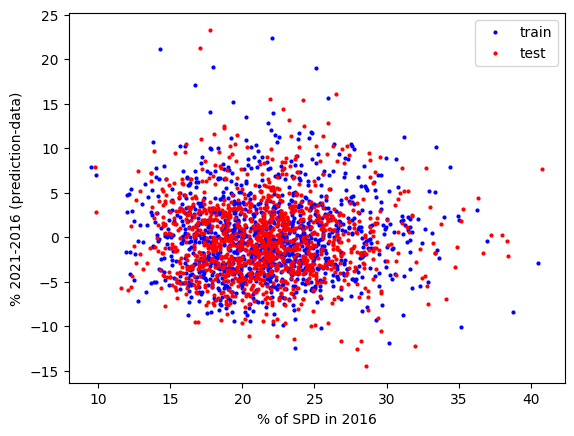

In [12]:
plt.plot(feat_train.iloc[:,0],predli1tr-tar_train,'o',ms=2,color='blue',label='train') 
plt.plot(feat_test.iloc[:,0],predli1te-tar_test,'o',ms=2,color='red',label='test') 
plt.legend(loc="best")
plt.xlabel("% of SPD in 2016")
plt.ylabel("% 2021-2016 (prediction-data)")

In [15]:
regx=XGBRegressor().fit(feat_train, tar_train)

Now I use as alternative XGBregressor.

In [16]:
predli1tex=regx.predict(feat_test)
predli1trx=regx.predict(feat_train)

In [17]:
print(f"standard deviation of test {round(np.std(predli1tex-tar_test),4)} %")
print(f"standard deviation of train {round(np.std(predli1trx-tar_train),4)} %")

standard deviation of test 5.1014 %
standard deviation of train 1.587 %


There is clear overfitting. 

Now I am adding more columns (parties) to the feature data. 

In [20]:
tar=cleaned.SPD_y/cleaned['Gültige Stimmen_y']*100-100*cleaned.SPD_x/cleaned['Gültige Stimmen_x']
tarc=cleaned.CDU_y/cleaned['Gültige Stimmen_y']*100-100*cleaned.CDU_x/cleaned['Gültige Stimmen_x']
tara=cleaned.AfD_y/cleaned['Gültige Stimmen_y']*100-100*cleaned.AfD_x/cleaned['Gültige Stimmen_x']
tarf=cleaned.FDP_y/cleaned['Gültige Stimmen_y']*100-100*cleaned.FDP_x/cleaned['Gültige Stimmen_x']
tarl=cleaned['DIE LINKE_y']/cleaned['Gültige Stimmen_y']*100-100*cleaned['DIE LINKE_x']/cleaned['Gültige Stimmen_x']
targ=cleaned.GRÜNE_y/cleaned['Gültige Stimmen_y']*100-100*cleaned.GRÜNE_x/cleaned['Gültige Stimmen_x']
ser1=cleaned.SPD_y/cleaned['Gültige Stimmen_y']*100
ser2=cleaned.CDU_y/cleaned['Gültige Stimmen_y']*100
ser3=cleaned.GRÜNE_y/cleaned['Gültige Stimmen_y']*100
ser4=cleaned.FDP_y/cleaned['Gültige Stimmen_y']*100
ser5=cleaned['DIE LINKE_y']/cleaned['Gültige Stimmen_y']*100
ser6=cleaned.AfD_y/cleaned['Gültige Stimmen_y']*100
#rest not needed follows automatically
ser7=100-ser1-ser2-ser3-ser4-ser5-ser6
print(ser6.mean(),ser7.mean())
feat2 = pd.concat([ser1,ser2,ser3,ser4,ser5,ser6],axis=1)

14.454342663803418 9.45232498695196


In [21]:
feat2_train,feat2_test,tar_train, tar_test,tarc_train, tarc_test,tara_train, tara_test,tarf_train, tarf_test,tarl_train, tarl_test,targ_train, targ_test= train_test_split(feat2,tar,tarc,tara,tarf,tarl,targ,train_size=0.50, shuffle=True, random_state=1)

In [22]:
reg2=LinearRegression().fit(feat2_train, tar_train)

In [23]:
predli1te2=reg2.predict(feat2_test)
predli1tr2=reg2.predict(feat2_train)

No I look again on the metrics.

In [24]:
print(f"standard deviation of data (train) {round(np.std(tar_train),4)} %")
print(f"standard deviation of data (test) {round(np.std(tar_test),4)} %")
print(f"standard deviation of train-data (train) {round(np.std(predli1tr2-tar_train),4)} %")
print(f"standard deviation of prediction-data (test) {round(np.std(predli1te2-tar_test),4)} %")

standard deviation of data (train) 4.9951 %
standard deviation of data (test) 4.8475 %
standard deviation of train-data (train) 4.2165 %
standard deviation of prediction-data (test) 4.0975 %


The metrics improve but only by a tiny bit and are still not really good. 

In [25]:
regx2=XGBRegressor().fit(feat2_train, tar_train)

In [27]:
predli1tex2=regx2.predict(feat2_test)
predli1trx2=regx2.predict(feat2_train)

In [28]:
print(f"standard deviation of test {round(np.std(predli1tex2-tar_test),4)} %")
print(f"standard deviation of train {round(np.std(predli1trx2-tar_train),4)} %")

standard deviation of test 4.2949 %
standard deviation of train 0.5884 %


XGB improves more compared to the previous version but is still slightly worse than linear regression. There is still clear overfitting.

Need to check whether it can be the dostrict matching. Or is it difficult party? 

Now CDU

In [29]:
def get_scatter(feature_train,feature_test,target_train,target_test,name):
    reg2c=LinearRegression().fit(feature_train, target_train)
    predli1te2c=reg2c.predict(feature_test)
    predli1tr2c=reg2c.predict(feature_train)
    reg2cx=XGBRegressor().fit(feature_train, target_train)
    predli1te2cx=reg2cx.predict(feature_test)
    predli1tr2cx=reg2cx.predict(feature_train)
    print(name)
    print(f"standard deviation of data (train) {round(np.std(target_train),4)} %")
    print(f"standard deviation of data (test) {round(np.std(target_test),4)} %")
    print(f"standard deviation of train-data (train) {round(np.std(predli1tr2c-target_train),4)} %")
    print(f"standard deviation of prediction-data (test) {round(np.std(predli1te2c-target_test),4)} %")
    print(f"standard deviation of train-data (train) XGB {round(np.std(predli1tr2cx-target_train),4)} %")
    print(f"standard deviation of prediction-data (test) XGB {round(np.std(predli1te2cx-target_test),4)} %")   

In [30]:
get_scatter(feat2_train,feat2_test,tarc_train,tarc_test,"CDU")

CDU
standard deviation of data (train) 4.6854 %
standard deviation of data (test) 4.5053 %
standard deviation of train-data (train) 4.3845 %
standard deviation of prediction-data (test) 4.2106 %
standard deviation of train-data (train) XGB 0.6297 %
standard deviation of prediction-data (test) XGB 4.586 %


In [31]:
get_scatter(feat2_train,feat2_test,targ_train,targ_test,"Gruene")

Gruene
standard deviation of data (train) 5.7667 %
standard deviation of data (test) 5.6388 %
standard deviation of train-data (train) 5.5366 %
standard deviation of prediction-data (test) 5.4037 %
standard deviation of train-data (train) XGB 0.6876 %
standard deviation of prediction-data (test) XGB 5.9799 %


In [32]:
get_scatter(feat2_train,feat2_test,tarl_train,tarl_test,"die Linke")

die Linke
standard deviation of data (train) 4.7148 %
standard deviation of data (test) 4.7748 %
standard deviation of train-data (train) 3.565 %
standard deviation of prediction-data (test) 3.5719 %
standard deviation of train-data (train) XGB 0.4581 %
standard deviation of prediction-data (test) XGB 3.7665 %


In [33]:
get_scatter(feat2_train,feat2_test,tara_train,tara_test,"AfD")

AfD
standard deviation of data (train) 3.6788 %
standard deviation of data (test) 3.5955 %
standard deviation of train-data (train) 3.1284 %
standard deviation of prediction-data (test) 2.9395 %
standard deviation of train-data (train) XGB 0.4102 %
standard deviation of prediction-data (test) XGB 3.1976 %


In [34]:
get_scatter(feat2_train,feat2_test,tarf_train,tarf_test,"FDP")

FDP
standard deviation of data (train) 2.9 %
standard deviation of data (test) 2.7637 %
standard deviation of train-data (train) 2.0895 %
standard deviation of prediction-data (test) 2.0707 %
standard deviation of train-data (train) XGB 0.2783 %
standard deviation of prediction-data (test) XGB 2.2696 %


All are similar, none is really good. XGB is not so good. On the other hand the real target is the average of them, thus the impact is not so high. 

Shoudl get impact on final important numbers, percentage and seats. 

Now looking into miss matching in matched ones

In [78]:
nulls=combined.Bezirksnummer_y.isnull()
nn_null=0
for i in range(1):
    if nulls[i]==False:
        print(combined.iloc[i,1:18])
        print(combined.iloc[i,53:69])
        print(combined.iloc[i,7])
        print(combined.iloc[i,58])
        print(combined.iloc[i,14])
        print(combined.iloc[i,65])
        print(combined.iloc[i,2])
        print(combined.iloc[i,54])
        nn_null+=1

Adresse                           01B1A
Bezirksnummer_x                       1
Bezirksname_x                     Mitte
Wahlbezirk_x                         1A
Wahlbezirksart_x                      B
Briefwahlbezirk                    011A
Abgeordneten-\nhauswahlkreis_x        1
Bundestags-\nwahlkreis_x             75
OstWest                               W
Wahlberechtigte insgesamt_x           0
Wahlberechtigte A1_x                  0
Wahlberechtigte A2_x                  0
Wahlberechtigte A3_x                  0
Wählende                           1079
Wählende B1                        1079
Gültige Stimmen_x                  1079
Ungültige Stimmen_x                   0
Name: 0, dtype: object
Stimmart_y                            Zweitstimme
Bezirksnummer_y                               1.0
Bezirksname_y                               Mitte
Wahlbezirk_y                                   1A
Wahlbezirksart_y                  Briefwahlbezirk
Abgeordneten-\nhauswahlkreis_y                1

In [79]:
for i in range(combined.shape[1]):
    if nulls[i]==False and (combined.iloc[i,7]!=combined.iloc[i,58] or combined.iloc[i,2]!=combined.iloc[i,54]) :
        print(combined.iloc[i,7])
        print(combined.iloc[i,58])
        nn_null+=1

All have the same election district, thus a missmatch problem is the earliest one level below. I look now into the voters of matched districts.

Text(0, 0.5, 'eligible Voters 2021/eligible Voters 2016')

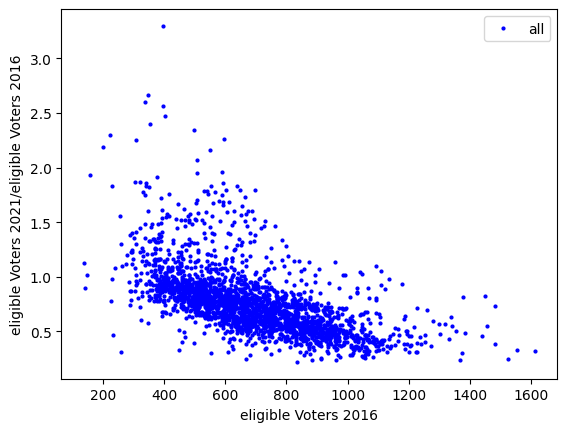

In [107]:
plt.plot(cleaned.iloc[:,65],cleaned.iloc[:,14]/cleaned.iloc[:,65],'o',ms=2,color='blue',label='all') 
plt.legend(loc="best")
plt.xlabel("eligible Voters 2016")
plt.ylabel("eligible Voters 2021/eligible Voters 2016")

In [58]:
ser=cleaned.iloc[:,14]/cleaned.iloc[:,65]
print(ser.describe())

count    2395.000000
mean        0.770010
std         0.302666
min         0.221292
25%         0.570362
50%         0.736593
75%         0.887853
max         3.297229
dtype: float64


Clearly not the same districts. Could use larger districts or figure out the border of the district. Could look whether first in one matches better. Likely best to find the id (map) for the districts. 

In [ ]:
Now I combined on election district level. It has a two index system. 

In [88]:
#first group by district is double index 
#elec_district16.set_index(['Bezirksnummer', 'Abgeordneten-\nhauswahlkreis'])
elec_district16=elec16_vote2.groupby([elec16_vote2['Bezirksnummer'],elec16_vote2['Abgeordneten-\nhauswahlkreis']]).sum()

/tmp/ipykernel_10334/2656201409.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  elec_district16=elec16_vote2.groupby([elec16_vote2['Bezirksnummer'],elec16_vote2['Abgeordneten-\nhauswahlkreis']]).sum()


In [90]:
elec_district21=elec21_vote2.groupby([elec21_vote2['Bezirksnummer'],elec21_vote2['Abgeordneten-\nhauswahlkreis']]).sum()

/tmp/ipykernel_10334/2124326953.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  elec_district21=elec21_vote2.groupby([elec21_vote2['Bezirksnummer'],elec21_vote2['Abgeordneten-\nhauswahlkreis']]).sum()


In [91]:
print(elec_district16.shape)
print(elec_district21.shape)
print(elec_district16)

(78, 35)
(78, 43)
                                            Bundestags-\nwahlkreis  \
Bezirksnummer Abgeordneten-\nhauswahlkreis                           
1             1                                               2175   
              2                                               2625   
              3                                               2550   
              4                                               2550   
              5                                               2400   
...                                                            ...   
12            2                                               2541   
              3                                               2541   
              4                                               2695   
              5                                               2387   
              6                                               2695   

                                            Wahlberechtigte insgesamt  

In [98]:
combined_district=elec_district16.merge(elec_district21,how='left',left_index=True,right_index=True)

In [99]:
print(combined_district.columns)

Index(['Bundestags-\nwahlkreis_x', 'Wahlberechtigte insgesamt_x',
       'Wahlberechtigte A1_x', 'Wahlberechtigte A2_x', 'Wahlberechtigte A3_x',
       'Wähler', 'Wähler B1', 'Ungültige Stimmen_x', 'Gültige Stimmen_x',
       'SPD_x', 'CDU_x', 'GRÜNE_x', 'DIE LINKE_x', 'PIRATEN_x', 'NPD_x',
       'FDP_x', 'Tierschutzpartei_x', 'pro Deutschland', 'Die PARTEI_x', 'BIG',
       'DKP_x', 'ödp', 'PSG', 'BüSo_x', 'B', 'DL', 'ALFA', 'Tierschutzallianz',
       'AfD_x', 'DIE EINHEIT', 'DIE VIOLETTEN', 'Graue Panther_x',
       'MENSCHLICHE WELT_x', 'MIETERPARTEI_x', 'Gesundheits-\nforschung',
       'Bundestags-\nwahlkreis_y', 'Wahlberechtigte insgesamt_y',
       'Wahlberechtigte A1_y', 'Wahlberechtigte A2_y', 'Wahlberechtigte A3_y',
       'Wählende', 'Wählende B1', 'Gültige Stimmen_y', 'Ungültige Stimmen_y',
       'SPD_y', 'CDU_y', 'GRÜNE_y', 'DIE LINKE_y', 'AfD_y', 'FDP_y',
       'Die PARTEI_y', 'Tierschutzpartei_y', 'PIRATEN_y', 'Graue Panther_y',
       'NPD_y', 'Gesundheitsforschung'

Text(0, 0.5, 'eligible Voters 2021/eligible Voters 2016')

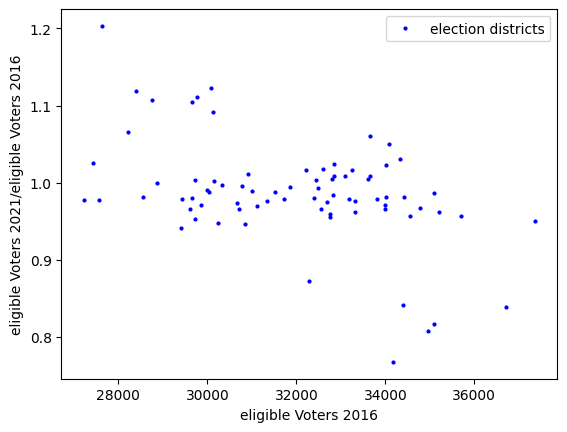

In [106]:
plt.plot(combined_district['Wahlberechtigte insgesamt_x'],combined_district['Wahlberechtigte insgesamt_y']/combined_district['Wahlberechtigte insgesamt_x'],'o',ms=2,color='blue',label='election districts') 
plt.legend(loc="best")
plt.xlabel("eligible Voters 2016")
plt.ylabel("eligible Voters 2021/eligible Voters 2016")

Looks better most are rather close 1, some a little off. 78 are clearly not enough for a good analysis and prediction. Spatial information on the districts is needed. 

In [112]:
combined_district['spd_%_16']=combined_district.SPD_x/combined_district['Gültige Stimmen_x']*100
combined_district['spd_%_21']=combined_district.SPD_y/combined_district['Gültige Stimmen_y']*100
combined_district['cdu_%_16']=combined_district.CDU_x/combined_district['Gültige Stimmen_x']*100
combined_district['cdu_%_21']=combined_district.CDU_y/combined_district['Gültige Stimmen_y']*100
combined_district['fdp_%_16']=combined_district.FDP_x/combined_district['Gültige Stimmen_x']*100
combined_district['fdp_%_21']=combined_district.FDP_y/combined_district['Gültige Stimmen_y']*100
combined_district['afd_%_16']=combined_district.AfD_x/combined_district['Gültige Stimmen_x']*100
combined_district['afd_%_21']=combined_district.AfD_y/combined_district['Gültige Stimmen_y']*100
combined_district['greens_%_16']=combined_district['GRÜNE_x']/combined_district['Gültige Stimmen_x']*100
combined_district['greens_%_21']=combined_district['GRÜNE_y']/combined_district['Gültige Stimmen_y']*100
combined_district['lefts_%_16']=combined_district['DIE LINKE_x']/combined_district['Gültige Stimmen_x']*100
combined_district['lefts_%_21']=combined_district['DIE LINKE_y']/combined_district['Gültige Stimmen_y']*100

Text(0, 0.5, 'party (2021)-party 2016 [%]')

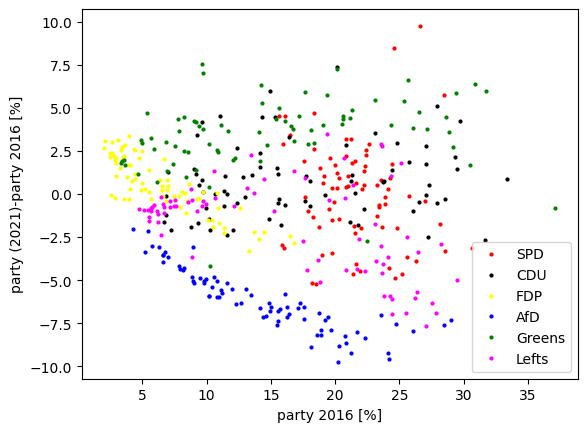

In [113]:
plt.plot(combined_district['spd_%_16'],combined_district['spd_%_21']-combined_district['spd_%_16'],'o',ms=2,color='red',label='SPD')
plt.plot(combined_district['cdu_%_16'],combined_district['cdu_%_21']-combined_district['cdu_%_16'],'o',ms=2,color='black',label='CDU') 
plt.plot(combined_district['fdp_%_16'],combined_district['fdp_%_21']-combined_district['fdp_%_16'],'o',ms=2,color='yellow',label='FDP') 
plt.plot(combined_district['afd_%_16'],combined_district['afd_%_21']-combined_district['afd_%_16'],'o',ms=2,color='blue',label='AfD')
plt.plot(combined_district['greens_%_16'],combined_district['greens_%_21']-combined_district['greens_%_16'],'o',ms=2,color='green',label='Greens') 
plt.plot(combined_district['lefts_%_16'],combined_district['lefts_%_21']-combined_district['lefts_%_16'],'o',ms=2,color='magenta',label='Lefts') 
plt.legend(loc="best")
plt.xlabel("party 2016 [%]")
plt.ylabel("party (2021)-party 2016 [%]")

Looking better now, at least some parties have a clear principle, SPD not. 